# TNG Property Distributions

In this notebook, we visualize the distribution of halo and galaxy properties in the IllustrisTNG simulations.

In [1]:
import numpy as np
import matplotlib
from matplotlib import pylab
%config InlineBackend.figure_format = 'retina'
matplotlib.rcParams['figure.dpi'] = 80
params = {'legend.fontsize': 'xx-large',
          'figure.figsize': (6, 4),
         'axes.labelsize': 'xx-large',
         'axes.titlesize': 'xx-large',
         'xtick.labelsize': 'x-large',
         'ytick.labelsize': 'x-large',
         'figure.facecolor': 'w'}
pylab.rcParams.update(params)
from matplotlib import pyplot as plt
import sys
import h5py
import matplotlib.gridspec as gridspec

# shouldn't need this if have illustris_python properly in python path! todo: check if fixed upon reload
sys.path.insert(1, '/home/ksf293/external')
import illustris_python as il

## Load in simulation data

Set up paths and variables:

In [2]:
tng_path_hydro = '/scratch/ksf293/gnn-cosmology/data/TNG50-4'
tng_path_dark = '/scratch/ksf293/gnn-cosmology/data/TNG50-4-Dark'
base_path_hydro = '/scratch/ksf293/gnn-cosmology/data/TNG50-4/output'
base_path_dark = '/scratch/ksf293/gnn-cosmology/data/TNG50-4-Dark/output'
snap_num = 99

In [3]:
ipart_dm = il.snapshot.partTypeNum('dm') # 0
ipart_star = il.snapshot.partTypeNum('stars') # 4
mass_multiplier = 1e10

Load in dark and full sims:

In [4]:
fields = ['SubhaloMass','SubhaloPos','SubhaloMassType', 'SubhaloLenType', 'SubhaloHalfmassRad', 'SubhaloGrNr']

subhalos_hydro = il.groupcat.loadSubhalos(base_path_hydro,snap_num,fields=fields)
halos_hydro = il.groupcat.loadHalos(base_path_hydro,snap_num)

subhalos_dark = il.groupcat.loadSubhalos(base_path_dark,snap_num,fields=fields)
halos_dark = il.groupcat.loadHalos(base_path_dark,snap_num)

Create corresponding array of halo IDS:

In [5]:
# I think the halo IDs are just the place in the original list; make this explicit
idxs_halos_hydro_all = np.array(list(range(halos_hydro['count'])))
idxs_halos_dark_all = np.array(list(range(halos_dark['count'])))

Load twin-matching file:

In [6]:
f = h5py.File(f'{tng_path_hydro}/postprocessing/subhalo_matching_to_dark.hdf5','r')
# two different matching algorithms: 'SubhaloIndexDark_LHaloTree' & 'SubhaloIndexDark_SubLink'. choosing first for now
subhalo_full_to_dark_inds = f[f'Snapshot_{snap_num}']['SubhaloIndexDark_LHaloTree']

Build dicts to match subhalos both ways. If a full subhalo has no dark subhalo twin, exclude it.

In [7]:
subhalo_full_to_dark_dict = {}
subhalo_dark_to_full_dict = {}
for i in range(len(subhalo_full_to_dark_inds)):
    idx_full = i
    idx_dark = subhalo_full_to_dark_inds[idx_full]
    if idx_dark == -1:
        continue
    subhalo_dark_to_full_dict[idx_dark] = idx_full
    subhalo_full_to_dark_dict[idx_full] = idx_dark

Get most massive subhalo in each dark halo; then find that subhalo's twin in the full sim. If it doesn't have a twin (aka not in dict), exclude. Then take the twin subhalo's parent halo; this is the associated hydro halo. Finally, take that hydro halo's most massive subhalo (this is most likely the original twin, but may not be).

Also, make some additional cuts:
- If there are no star particles in the matched subhalo in the full sim, exclude.
- If the dark matter halo has a mass below some minimum mass, exclude.
- If the hydro halo is too many times bigger than the associated dark halo, exclude (it is probably a bad match).

In [8]:
# GroupFirstSub: Index into the Subhalo table of the first/primary/most massive 
# Subfind group within this FoF group. Note: This value is signed (or should be interpreted as signed)! 
# In this case, a value of -1 indicates that this FoF group has no subhalos.
halos_dark['GroupFirstSub'] = halos_dark['GroupFirstSub'].astype('int32')
mask_has_subhalos = np.where(halos_dark['GroupFirstSub'] >= 0) # filter out halos with no subhalos

idxs_halos_dark_withsubhalos = idxs_halos_dark_all[mask_has_subhalos]
idxs_largestsubs_dark_all = halos_dark['GroupFirstSub'][mask_has_subhalos]

halo_dicts = []
for i, idx_halo_dark in enumerate(idxs_halos_dark_withsubhalos):
    
    idx_largestsub_dark = idxs_largestsubs_dark_all[i]
    if idx_largestsub_dark in subhalo_dark_to_full_dict:
        
        halo_dict = {}
        
        # This is the index of the hydro subhalo that is the twin of the largest subhalo in the dark halo
        idx_subtwin_hydro = subhalo_dark_to_full_dict[idx_largestsub_dark]
        # This is that hydro subhalo's parent halo in the hydro sim
        idx_halo_hydro = subhalos_hydro['SubhaloGrNr'][idx_subtwin_hydro]
        # This is the largest hydro subhalo of that hydro halo
        idx_subhalo_hydro = halos_hydro['GroupFirstSub'][idx_halo_hydro]

        # if no stars in this subhalo, exclude
        epsilon = 1e-6 #magic
        if subhalos_hydro['SubhaloMassType'][:,ipart_star][idx_subhalo_hydro] < epsilon: 
            continue

        # if halo is below a minimum mass, exclude
        mass_min = 1.0 #magic #units 1e10
        if halos_dark['GroupMass'][idx_halo_dark] < mass_min: 
            continue
            
        # if halo masses differ, exclude
        diff_fac = 3.0 #magic
        if halos_hydro['GroupMass'][idx_halo_hydro] > diff_fac*halos_dark['GroupMass'][idx_halo_dark]: 
            continue
        
        halo_dict['idx_halo_dark'] = idx_halo_dark
        halo_dict['idx_subhalo_hydro'] = idx_subhalo_hydro
        halo_dict['idx_subhalo_dark'] = idx_largestsub_dark
        halo_dict['idx_halo_hydro'] = idx_halo_hydro
        
        halo_dicts.append(halo_dict)
        
halo_dicts = np.array(halo_dicts)

In [9]:
print('Number dark halos in dark sim:', len(idxs_halos_dark_all))
print('Number dark halos with >=1 subhalo:', len(idxs_halos_dark_withsubhalos))
print('Number dark subhalos with a twin in full sim:', len(subhalo_dark_to_full_dict))
print('Number halos after additional cuts above:', len(halo_dicts))
N_halos = len(halo_dicts)
idx_halos_in_halodict = np.arange(N_halos)

Number dark halos in dark sim: 18824
Number dark halos with >=1 subhalo: 17738
Number dark subhalos with a twin in full sim: 18392
Number halos after additional cuts above: 2342


## Plot property distributions of entire simulation

### Number of particles per halo

In [10]:
mask_has_stars = np.where(halos_hydro['GroupLenType'][:,ipart_star]>0)[0]

halos_dark['GroupFirstSub'] = halos_dark['GroupFirstSub'].astype('int32')
mask_has_subhalos = np.where(halos_dark['GroupFirstSub'] >= 0)[0] # filter out halos with no subhalos (-1 means no subhalo)

In [11]:
print('Number of dark halos:', halos_dark['count'])
print('Number of dark halos with >=1 subhalo:', len(mask_has_subhalos))
print('Number of hydro halos:', halos_hydro['count'])
print('Number of hydro halos with star particles:', len(mask_has_stars))

Number of dark halos: 18824
Number of dark halos with >=1 subhalo: 17738
Number of hydro halos: 25257
Number of hydro halos with star particles: 2541


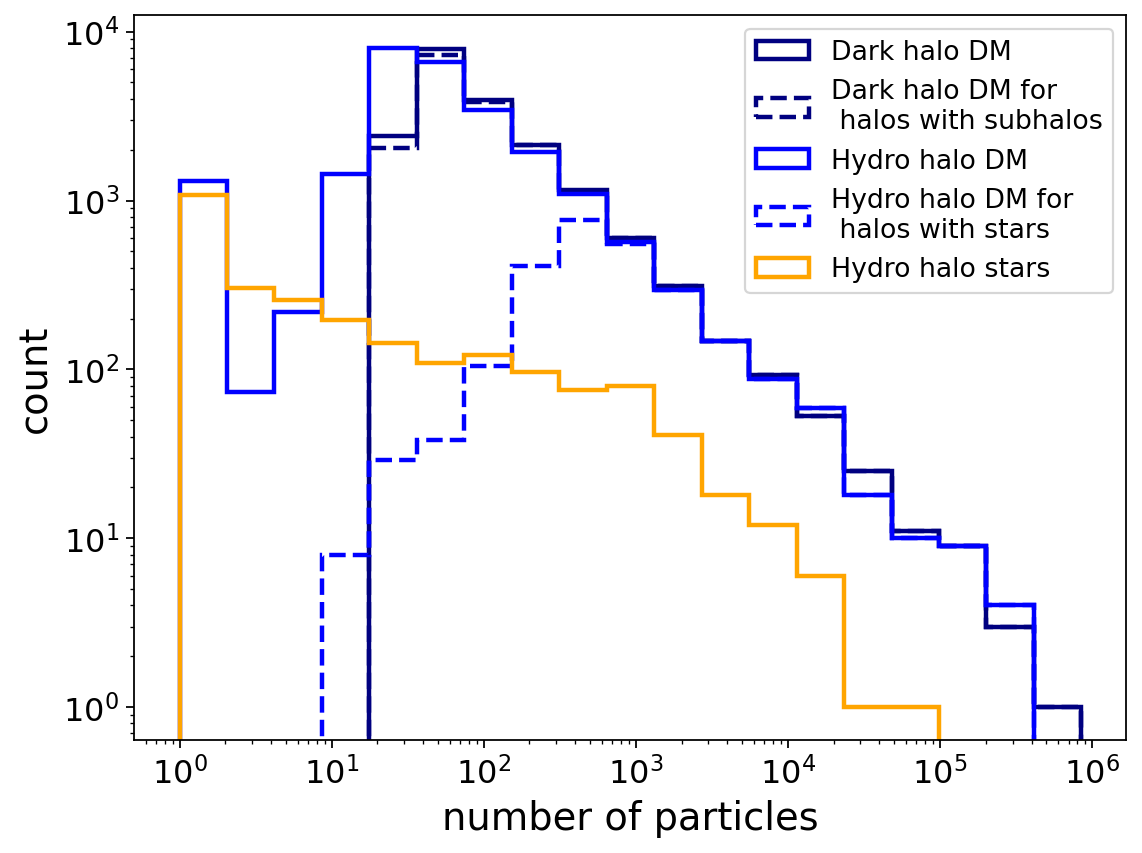

In [12]:
plt.figure(figsize=(8,6))

# all halos in sims
n_bins = 20
bins = np.logspace(np.log10(1), np.log10(max(halos_hydro['GroupLenType'][:,ipart_dm])), n_bins)
_ = plt.hist(halos_dark['GroupLenType'][:,ipart_dm], bins=bins, log=True, histtype='step', 
             color='navy', lw=2, label='Dark halo DM')
_ = plt.hist(halos_dark['GroupLenType'][:,ipart_dm][mask_has_subhalos], bins=bins, log=True, histtype='step', 
             color='navy', lw=2, ls='--', label='Dark halo DM for \n halos with subhalos')
_ = plt.hist(halos_hydro['GroupLenType'][:,ipart_dm], bins=bins, log=True, histtype='step', 
             color='blue', lw=2, label='Hydro halo DM')
_ = plt.hist(halos_hydro['GroupLenType'][:,ipart_dm][mask_has_stars], bins=bins, log=True, histtype='step', 
             color='blue', lw=2, ls='--', label='Hydro halo DM for \n halos with stars')
_ = plt.hist(halos_hydro['GroupLenType'][:,ipart_star], bins=bins, log=True, histtype='step', 
             color='orange', lw=2, label='Hydro halo stars')

plt.xscale('log')
plt.xlabel('number of particles')
plt.ylabel('count')
plt.legend(fontsize=12)

### Mass of halo

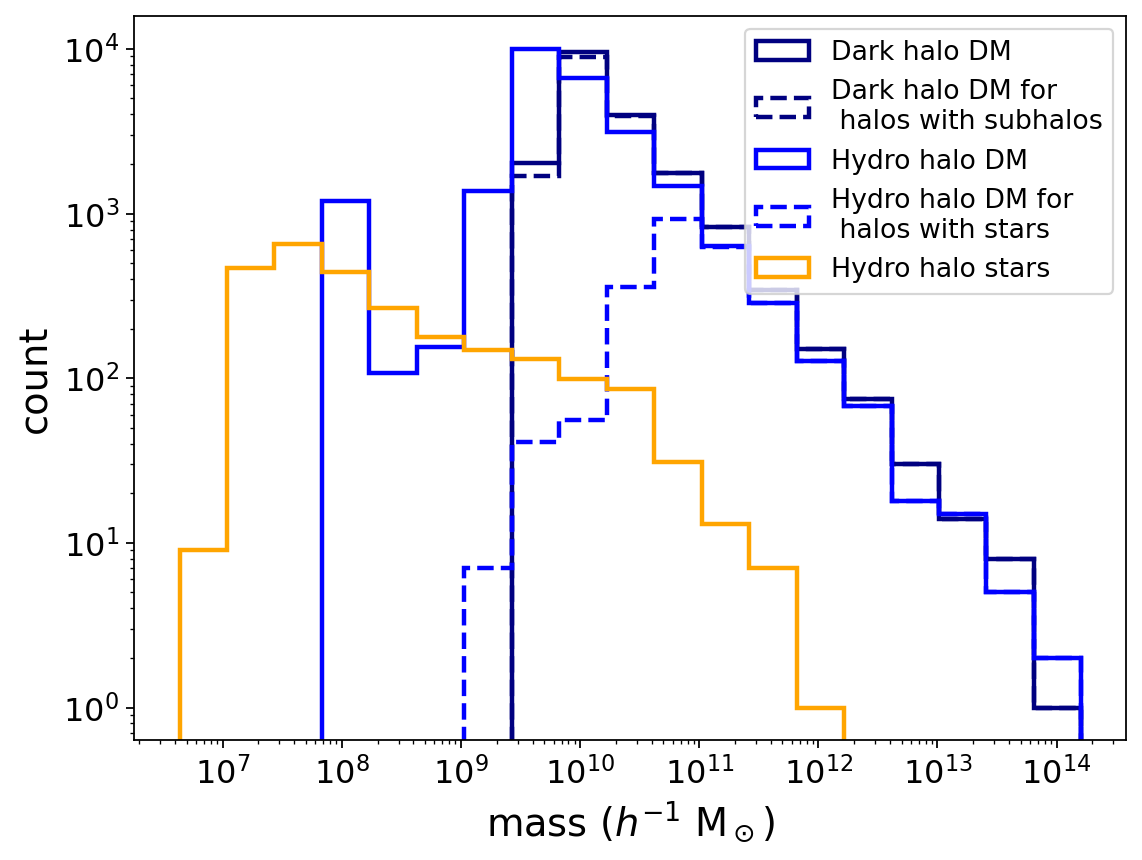

In [13]:
plt.figure(figsize=(8,6))

n_bins = 20
bins = np.logspace(np.log10(min(halos_hydro['GroupMassType'][:,ipart_star][np.nonzero(halos_hydro['GroupMassType'][:,ipart_star])])*mass_multiplier), 
                   np.log10(max(halos_dark['GroupMassType'][:,ipart_dm])*mass_multiplier), n_bins)
_ = plt.hist(halos_dark['GroupMassType'][:,ipart_dm]*mass_multiplier, bins=bins, log=True, histtype='step', 
             color='navy', lw=2, label='Dark halo DM')
_ = plt.hist(halos_dark['GroupMassType'][:,ipart_dm][mask_has_subhalos]*mass_multiplier, bins=bins, log=True, histtype='step', 
             color='navy', lw=2, ls='--', label='Dark halo DM for \n halos with subhalos')
_ = plt.hist(halos_hydro['GroupMassType'][:,ipart_dm]*mass_multiplier, bins=bins, log=True, histtype='step', 
             color='blue', lw=2, label='Hydro halo DM')
_ = plt.hist(halos_hydro['GroupMassType'][:,ipart_dm][mask_has_stars]*mass_multiplier, bins=bins, log=True, histtype='step', 
             color='blue', lw=2, ls='--', label='Hydro halo DM for \n halos with stars')
_ = plt.hist(halos_hydro['GroupMassType'][:,ipart_star]*mass_multiplier, bins=bins, log=True, histtype='step', 
             color='orange', lw=2, label='Hydro halo stars')

plt.xscale('log')
plt.xlabel(r'mass ($h^{-1}$ M$_\odot)$')
plt.ylabel('count')
plt.legend(fontsize=12)

## Plot property distributions for our *matched* halo set:

In [14]:
N_halos = len(halo_dicts)

n_particles_dark_halo_dm = np.empty(N_halos)
n_particles_hydro_halo_dm = np.empty(N_halos)
n_particles_hydro_halo_star = np.empty(N_halos)
n_particles_hydro_subhalo_star = np.empty(N_halos)

mass_dark_halo_dm = np.empty(N_halos)
mass_hydro_halo_dm = np.empty(N_halos)
mass_hydro_halo_star = np.empty(N_halos)
mass_hydro_halo_all = np.empty(N_halos)
mass_hydro_subhalo_star = np.empty(N_halos)

for i_hd, halo_dict in enumerate(halo_dicts):
    
    idx_halo_dark = halo_dict['idx_halo_dark']
    n_particles_dark_halo_dm[i_hd] = halos_dark['GroupLenType'][:,ipart_dm][idx_halo_dark]
    mass_dark_halo_dm[i_hd] = halos_dark['GroupMassType'][:,ipart_dm][idx_halo_dark]

    idx_halo_hydro = halo_dict['idx_halo_hydro']
    n_particles_hydro_halo_dm[i_hd] = halos_hydro['GroupLenType'][:,ipart_dm][idx_halo_hydro]
    mass_hydro_halo_dm[i_hd] = halos_hydro['GroupMassType'][:,ipart_dm][idx_halo_hydro]
    n_particles_hydro_halo_star[i_hd] = halos_hydro['GroupLenType'][:,ipart_star][idx_halo_hydro]
    mass_hydro_halo_star[i_hd] = halos_hydro['GroupMassType'][:,ipart_star][idx_halo_hydro]
    mass_hydro_halo_all[i_hd] = halos_hydro['GroupMass'][idx_halo_hydro]
    
    idx_subhalo_hydro = halo_dict['idx_subhalo_hydro']
    n_particles_hydro_subhalo_star[i_hd] = subhalos_hydro['SubhaloLenType'][:,ipart_star][idx_subhalo_hydro]
    mass_hydro_subhalo_star[i_hd] = subhalos_hydro['SubhaloMassType'][:,ipart_star][idx_subhalo_hydro]

### Number of particles per halo

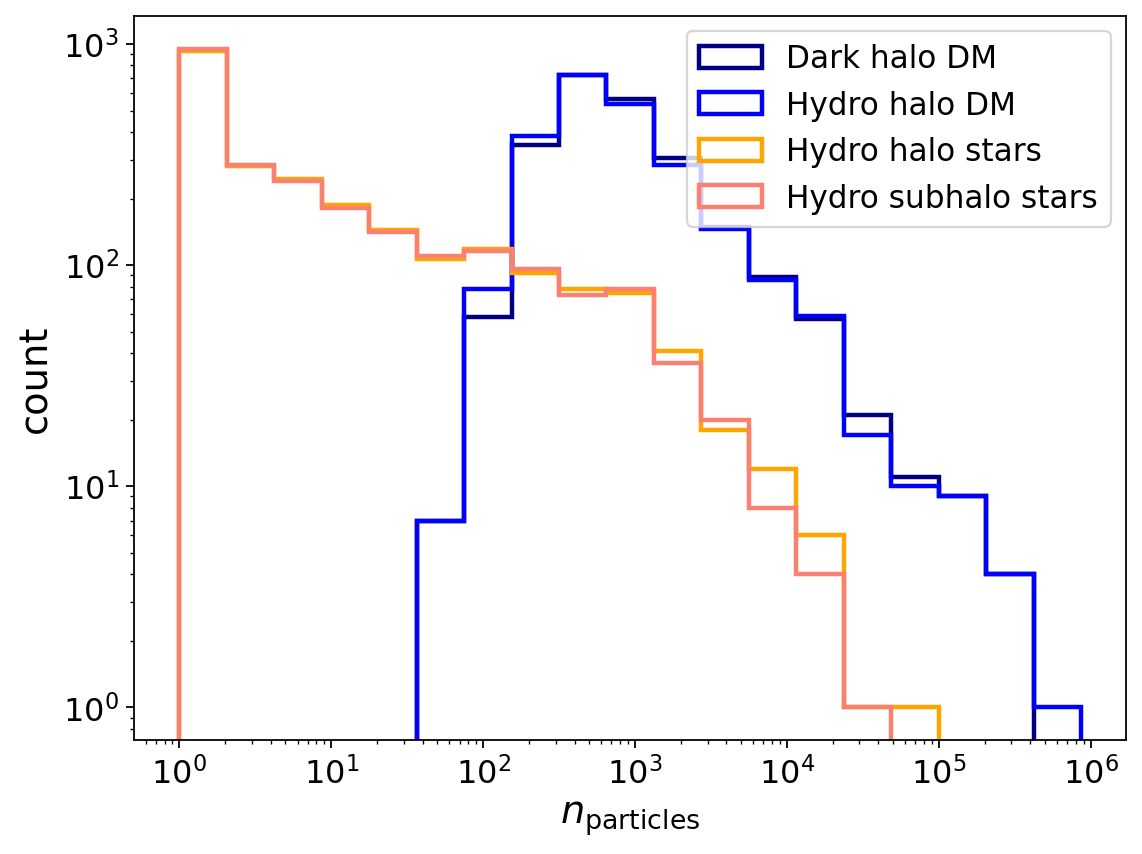

In [15]:
plt.figure(figsize=(8,6))

n_bins = 20
bins = np.logspace(np.log10(1), np.log10(max(n_particles_dark_halo_dm)), n_bins)
_ = plt.hist(n_particles_dark_halo_dm, bins=bins, log=True, histtype='step', 
             color='navy', lw=2, label='Dark halo DM')
_ = plt.hist(n_particles_hydro_halo_dm, bins=bins, log=True, histtype='step', 
             color='blue', lw=2, label='Hydro halo DM')
_ = plt.hist(n_particles_hydro_halo_star, bins=bins, log=True, histtype='step', 
             color='orange', lw=2, label='Hydro halo stars')
_ = plt.hist(n_particles_hydro_subhalo_star, bins=bins, log=True, histtype='step', 
             color='salmon', lw=2, label='Hydro subhalo stars')

plt.xscale('log')
plt.xlabel(r'$n_\mathrm{particles}$')
plt.ylabel('count')
plt.legend(fontsize=14)

In [16]:
print("Number of halos:", N_halos)
print("Number of halos with stars:", len(np.nonzero(n_particles_hydro_halo_star)[0]))

Number of halos: 2342
Number of halos with stars: 2342


### Mass of (sub)halo

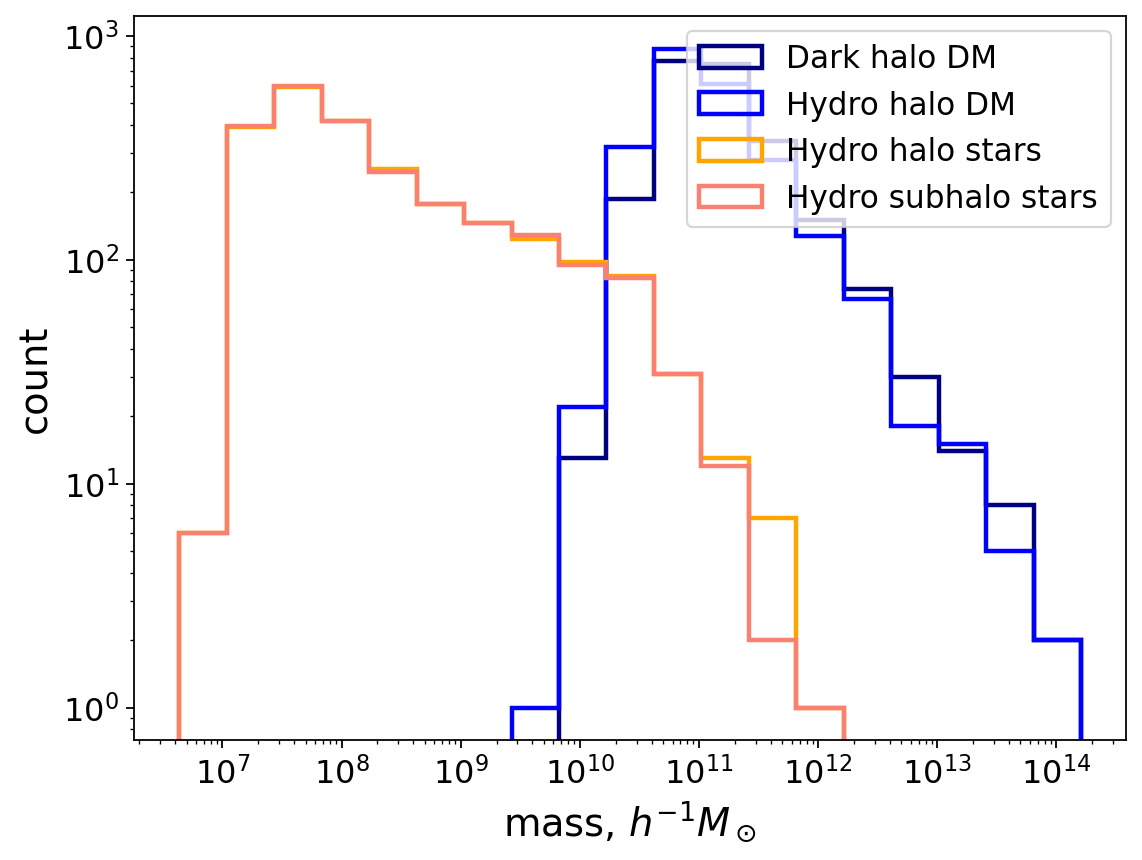

In [17]:
plt.figure(figsize=(8,6))

n_bins = 20
bins = np.logspace(np.log10(min(mass_hydro_subhalo_star[np.nonzero(mass_hydro_subhalo_star)])*mass_multiplier), 
                   np.log10(max(mass_dark_halo_dm)*mass_multiplier), n_bins)
_ = plt.hist(mass_dark_halo_dm*mass_multiplier, bins=bins, log=True, histtype='step', 
             color='navy', lw=2, label='Dark halo DM')
_ = plt.hist(mass_hydro_halo_dm*mass_multiplier, bins=bins, log=True, histtype='step', 
             color='blue', lw=2, label='Hydro halo DM')
_ = plt.hist(mass_hydro_halo_star*mass_multiplier, bins=bins, log=True, histtype='step', 
             color='orange', lw=2, label='Hydro halo stars')
_ = plt.hist(mass_hydro_subhalo_star*mass_multiplier, bins=bins, log=True, histtype='step', 
             color='salmon', lw=2, label='Hydro subhalo stars')

plt.xscale('log')
plt.xlabel('mass, $h^{-1} M_\odot$')
plt.ylabel('count')
plt.legend(fontsize=14)

In [18]:
print(min(mass_hydro_halo_star[np.nonzero(mass_hydro_halo_star)[0]]), max(mass_hydro_halo_star))
print(len(mass_hydro_halo_star), len(np.nonzero(mass_hydro_halo_star)[0]))

0.0004349329392425716 138.6913299560547
2342 2342


### Number of star vs DM particles 

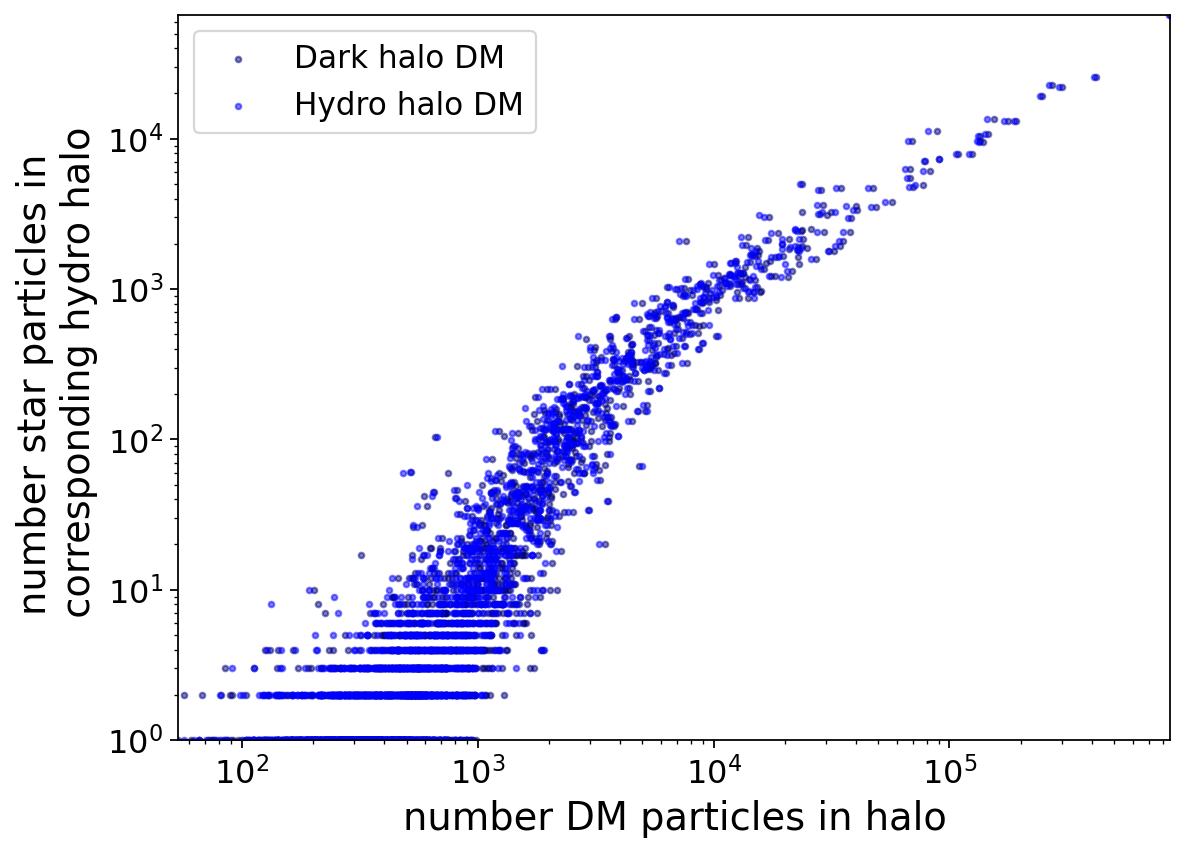

In [19]:
plt.figure(figsize=(8,6))
#plt.scatter(mass_dark_halo_dm*mass_multiplier, mass_hydro_halo_star*mass_multiplier, s=6, alpha=0.5, c='k')
plt.scatter(n_particles_dark_halo_dm, n_particles_hydro_halo_star, 
            s=6, alpha=0.5, c='navy', label='Dark halo DM')
plt.scatter(n_particles_hydro_halo_dm, n_particles_hydro_halo_star, 
            s=6, alpha=0.5, c='blue', label='Hydro halo DM')
plt.xlabel("number DM particles in halo")
plt.ylabel("number star particles in \n corresponding hydro halo")
plt.xscale('log')
plt.yscale('log')
plt.xlim([min(n_particles_dark_halo_dm), max(n_particles_dark_halo_dm)])
plt.ylim([min(n_particles_hydro_halo_star[np.nonzero(n_particles_hydro_halo_star)]), max(n_particles_hydro_halo_star)])

plt.legend(fontsize=14)

In [20]:
len(mass_dark_halo_dm), len(mass_hydro_halo_star)

(2342, 2342)

### Mass of hydro vs DM halo

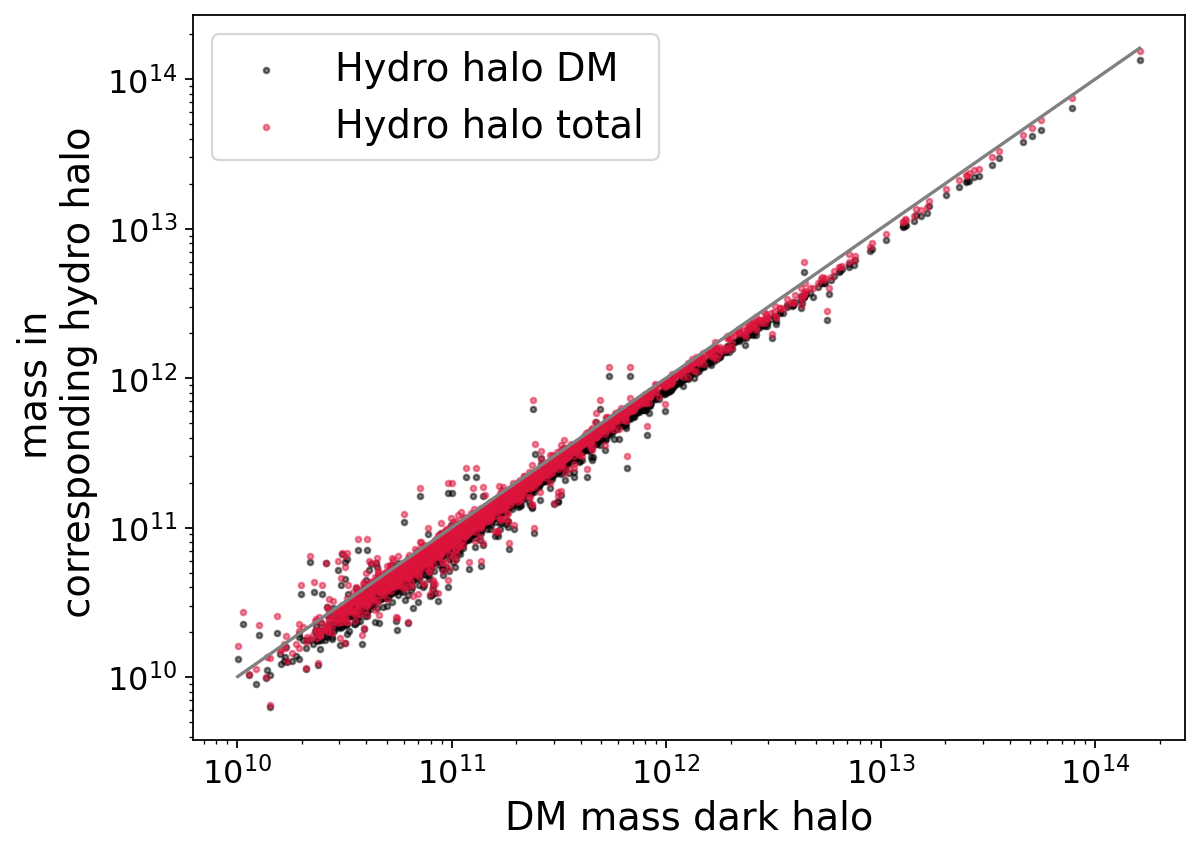

In [21]:
plt.figure(figsize=(8,6))
plt.scatter(mass_dark_halo_dm*mass_multiplier, mass_hydro_halo_dm*mass_multiplier, s=6, alpha=0.5,
            c='k', label='Hydro halo DM')
plt.scatter(mass_dark_halo_dm*mass_multiplier, mass_hydro_halo_all*mass_multiplier, s=6, alpha=0.5, 
            c='crimson', label='Hydro halo total')
plt.xlabel("DM mass dark halo")
plt.ylabel("mass in \n corresponding hydro halo")
plt.xscale('log')
plt.yscale('log')

mmin, mmax = [min(mass_dark_halo_dm[np.nonzero(mass_dark_halo_dm)])*mass_multiplier, 
              max(mass_dark_halo_dm)*mass_multiplier]
xx = np.linspace(mmin, mmax, 2)
plt.plot(xx, xx, color='grey')

plt.legend()

### Stellar mass of hydro halo vs DM mass of dark halo

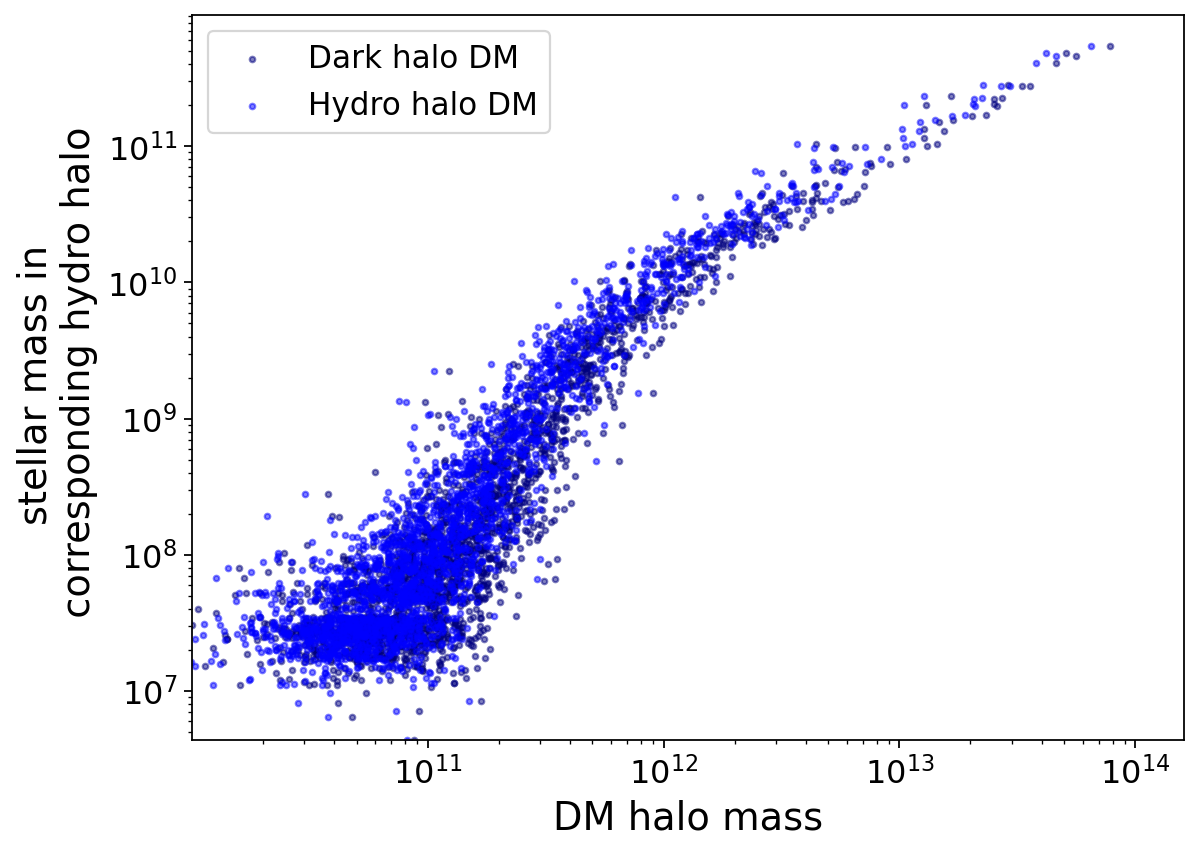

In [22]:
plt.figure(figsize=(8,6))
plt.scatter(mass_dark_halo_dm*mass_multiplier, mass_hydro_halo_star*mass_multiplier, 
            s=6, alpha=0.5, c='navy', label='Dark halo DM')
plt.scatter(mass_hydro_halo_dm*mass_multiplier, mass_hydro_halo_star*mass_multiplier, 
            s=6, alpha=0.5, c='blue', label='Hydro halo DM')

plt.xlabel("DM halo mass")
plt.ylabel("stellar mass in \n corresponding hydro halo")
plt.xscale('log')
plt.yscale('log')
plt.xlim([min(mass_dark_halo_dm[np.nonzero(mass_dark_halo_dm)])*mass_multiplier, 
          max(mass_dark_halo_dm)*mass_multiplier])
plt.ylim([min(mass_hydro_subhalo_star[np.nonzero(mass_hydro_subhalo_star)])*mass_multiplier, 
          max(mass_hydro_subhalo_star)*mass_multiplier])

plt.legend(fontsize=14)

## Plot a sample of halos

In [23]:
def plot_halos_dark_and_hydro(halo_dicts, nrows_outer, ncols_outer, titles):
    
    sub_width, sub_height = 5.5, 5
    fig = plt.figure(figsize=(sub_width*ncols_outer, sub_height*nrows_outer*2))

    outer = gridspec.GridSpec(nrows_outer, ncols_outer, wspace=0.5, hspace=0.25)

    nrows_inner = 2
    ncols_inner = 1
    
    for i_hd, halo_dict in enumerate(halo_dicts):

        inner = gridspec.GridSpecFromSubplotSpec(nrows_inner, ncols_inner,
                        subplot_spec=outer[i_hd],
                        height_ratios=[1,1],
                        hspace=0.0)

        ax0 = plt.Subplot(fig, inner[0])
        ax1 = plt.Subplot(fig, inner[1])
        axarr = [ax0, ax1]
        
        ax0.set_title(titles[i_hd], pad=10)
        alpha = 0.5
        
        # Dark sim
        idx_halo_dark = halo_dict['idx_halo_dark']
        halo_dark_dm = il.snapshot.loadHalo(base_path_dark,snap_num,idx_halo_dark,'dm')
        x_halo_dark_dm = halo_dark_dm['Coordinates']
        ax0.scatter(x_halo_dark_dm[:,0], x_halo_dark_dm[:,1], 
                   s=30, alpha=alpha, marker='.', color='darkblue', label='Dark halo DM')
        
        # Hydro sim
        idx_halo_hydro = halo_dict['idx_halo_hydro']
        halo_hydro_dm = il.snapshot.loadHalo(base_path_hydro,snap_num,idx_halo_hydro,'dm')
        x_halo_hydro_dm = halo_hydro_dm['Coordinates']
        ax1.scatter(x_halo_hydro_dm[:,0], x_halo_hydro_dm[:,1], 
                   s=30, alpha=alpha, marker='.', color='blue', label='Hydro halo DM')
        
        halo_hydro_stars = il.snapshot.loadHalo(base_path_hydro,snap_num,idx_halo_hydro,'stars')
        if halo_hydro_stars['count'] > 0:
            x_halo_hydro_stars = halo_hydro_stars['Coordinates']
            ax1.scatter(x_halo_hydro_stars[:,0], x_halo_hydro_stars[:,1], 
                       s=60, alpha=alpha, marker='.', color='orange', label='Hydro halo stars')

        # Set labels 
        ax0.set_ylabel(r'$y$')
        
        ax1.set_xlabel(r'$x$')
        ax1.set_ylabel(r'$y$')
        
        ax0.text(0.5, 0.9, 'dark', fontsize=16, horizontalalignment='center',
                 verticalalignment='center', transform=ax0.transAxes)
        ax1.text(0.5, 0.9, 'hydro', fontsize=16, horizontalalignment='center',
                 verticalalignment='center', transform=ax1.transAxes)
        

        # Set limits
        x_min = np.min([ax0.get_xlim()[0], ax1.get_xlim()[0]])
        x_max = np.max([ax0.get_xlim()[1], ax1.get_xlim()[1]])
        ax0.set_xlim([x_min, x_max])
        ax1.set_xlim([x_min, x_max])
        
        y_min = np.min([ax0.get_ylim()[0], ax1.get_ylim()[0]])
        y_max = np.max([ax0.get_ylim()[1], ax1.get_ylim()[1]])
        ax0.set_ylim([y_min, y_max])
        ax1.set_ylim([y_min, y_max])
        
        plt.setp(ax0.get_xticklabels(), visible=False)
    
        # Crosshairs at center of mass of DM particles of halos
        dark_color = 'grey'
        lw = 0.8
        com_dark = np.mean(x_halo_dark_dm, axis=0)
        ax0.axvline(com_dark[0], c=dark_color, lw=lw, label='CoM of dark halo DM particles')
        ax0.axhline(com_dark[1], c=dark_color, lw=lw)
        ax1.axvline(com_dark[0], c=dark_color, lw=lw)
        ax1.axhline(com_dark[1], c=dark_color, lw=lw)
        
        light_color = 'skyblue'
        com_hydro = np.mean(x_halo_hydro_dm, axis=0)
        ax0.axvline(com_hydro[0], c=light_color, lw=lw, label='CoM of hydro halo DM particles')
        ax0.axhline(com_hydro[1], c=light_color, lw=lw)
        ax1.axvline(com_hydro[0], c=light_color, lw=lw)
        ax1.axhline(com_hydro[1], c=light_color, lw=lw)
    
        # Add subplots
        fig.add_subplot(ax0)
        fig.add_subplot(ax1)
        fig.align_ylabels(axarr)

    handles0, labels0 = ax0.get_legend_handles_labels()
    handles1, labels1 = ax1.get_legend_handles_labels()
    handles = np.concatenate((handles0, handles1))
    labels = np.concatenate((labels0, labels1))
    plt.legend(handles, labels, fontsize=18, loc=(1.2, 4))

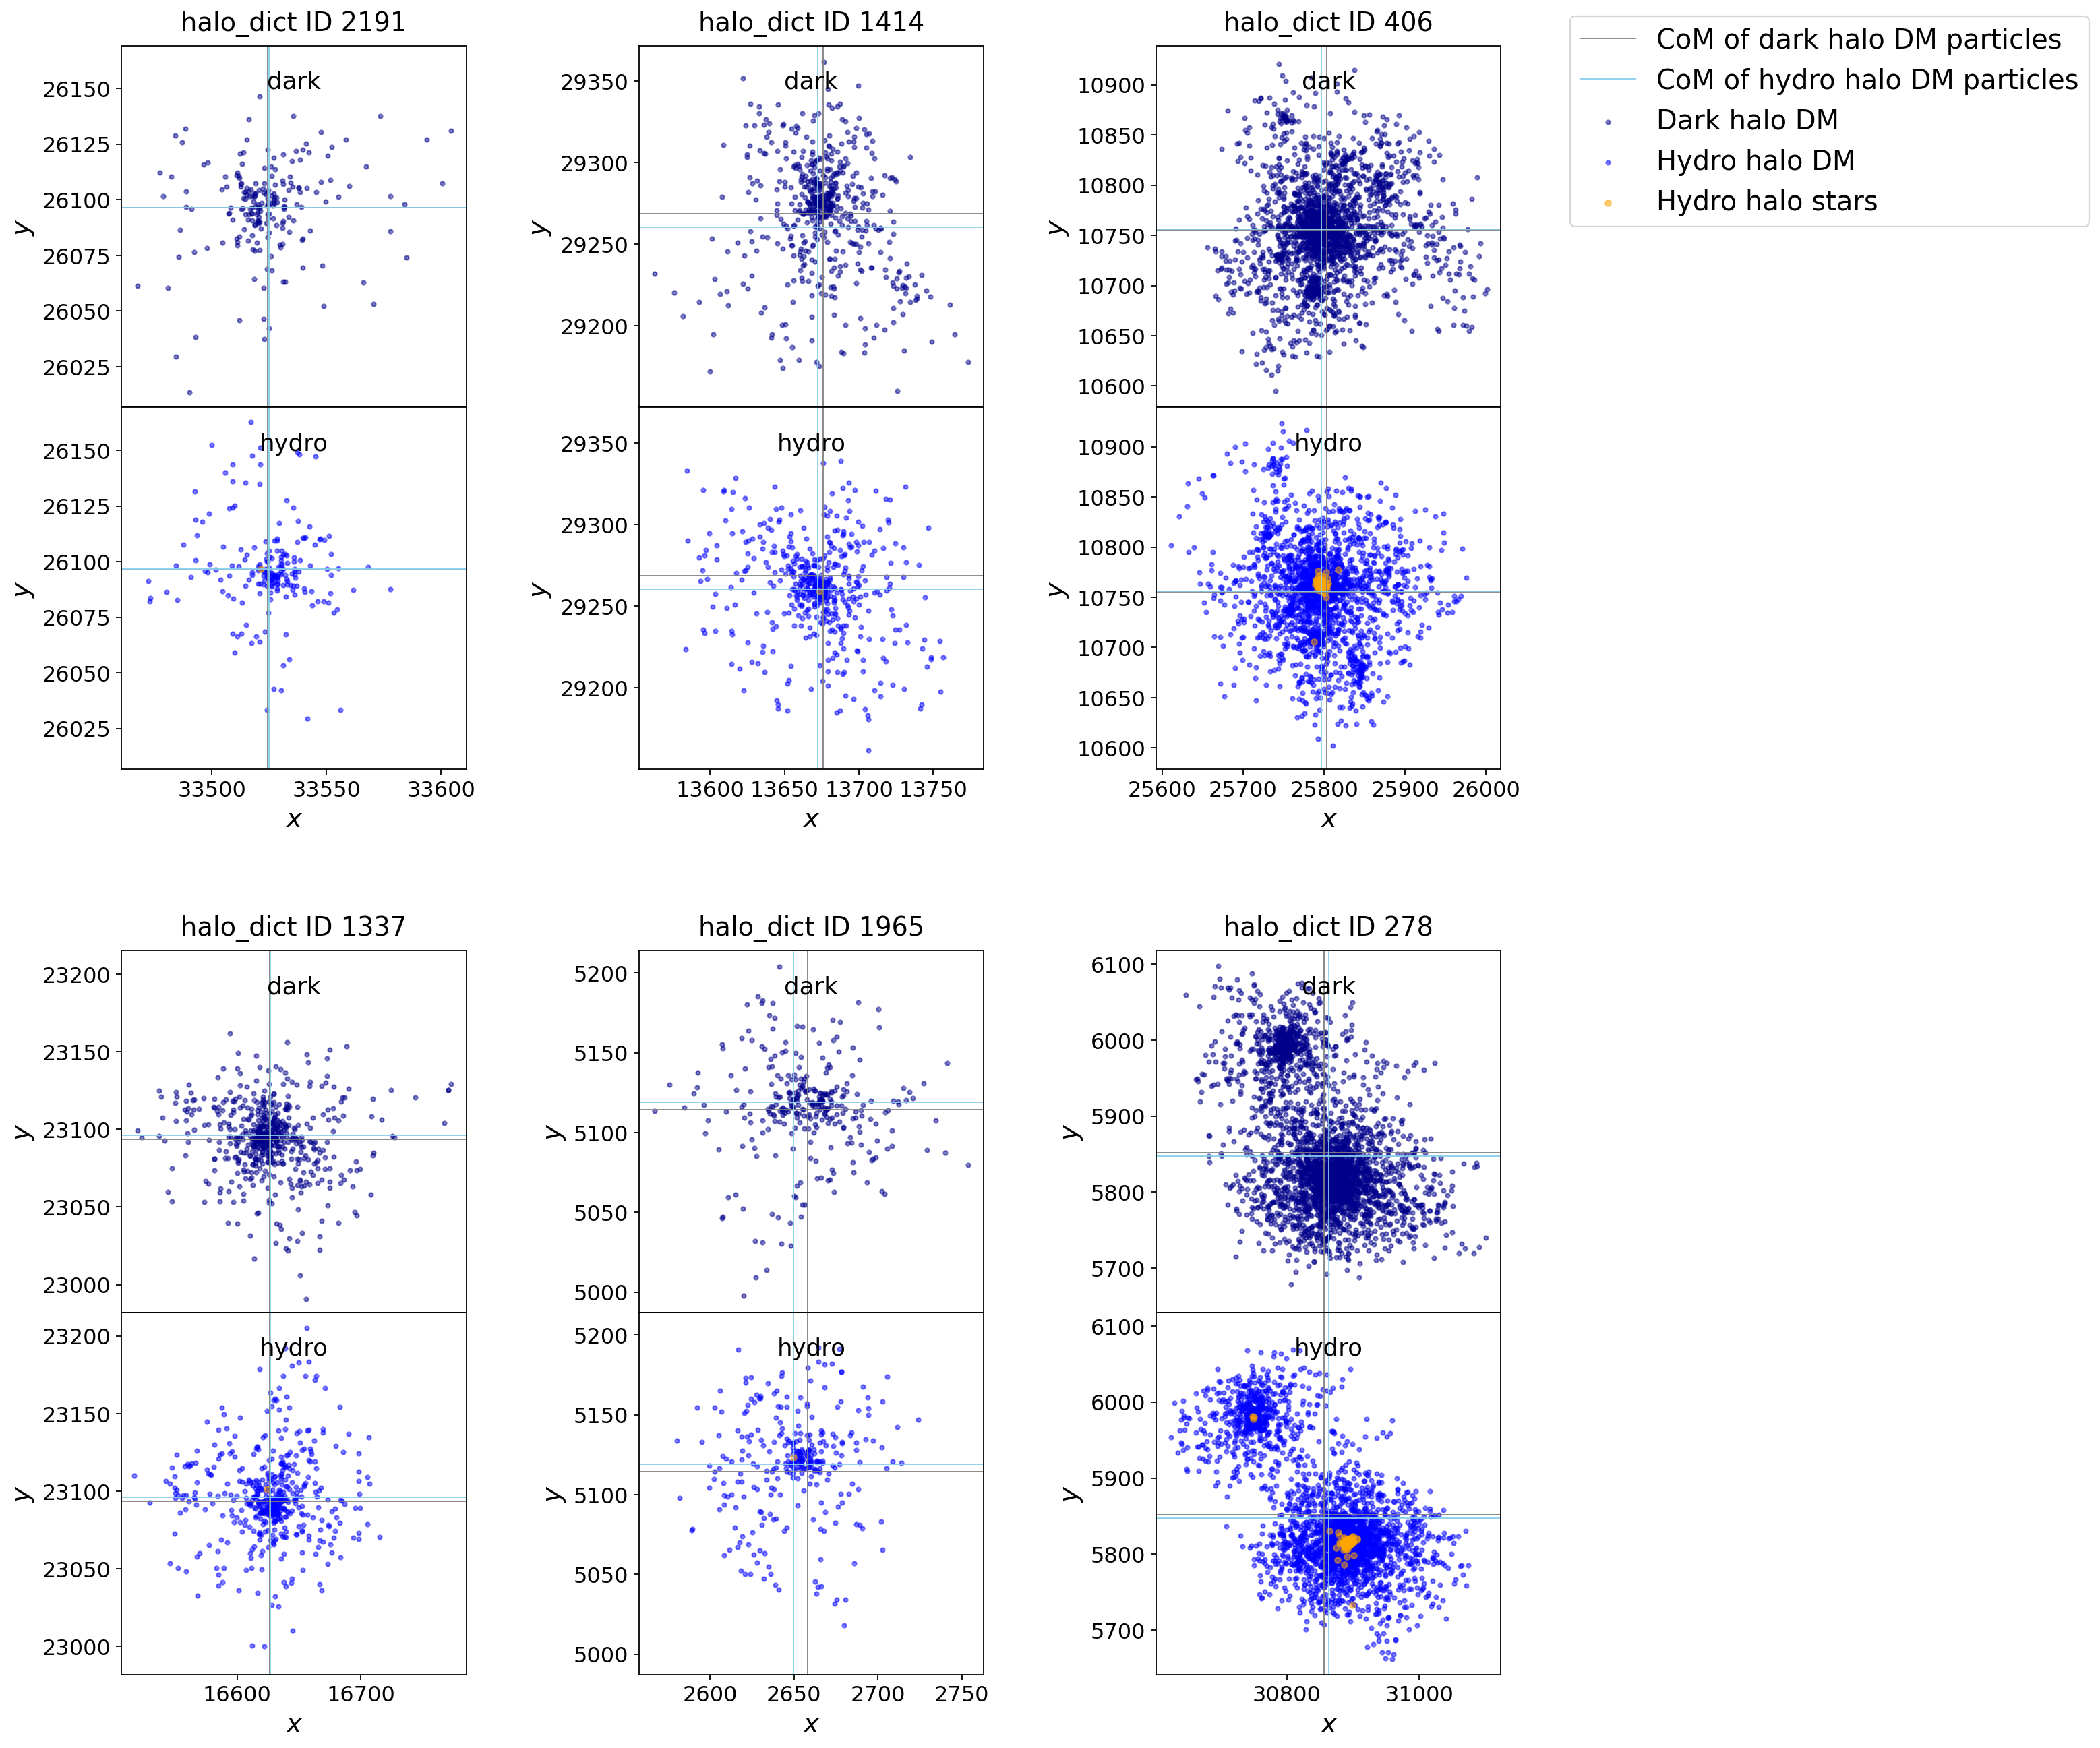

In [24]:
nrows = 2
ncols = 3
np.random.seed(17)
i_hds = np.random.randint(N_halos, size=nrows*ncols)
titles = [f'halo_dict ID {i_hd}' for i_hd in i_hds]
plot_halos_dark_and_hydro(halo_dicts[i_hds], nrows, ncols, titles=titles)